# Amazon Reviews Classification Analysis

In this notebook we will develop a classification model to categorize Amazon reviews and their product purchase ratings related to sports and outdoor activities. The ratings, which range from 1 (low rating) to 5 (highest rating), will be included in the categorization process.

# Table of Contents

1. Section 1 - Exploratory Data Analysis
2. Section 2 - Text Preprocessing - Lemmatization
3. Section 3 - Feature Representation using TFIDF
4. Section 4 - Model Building
5. Section 5 - Model Text as Sequence using Word Embedding and LSTM
6. Section 6 - Topic Modeling

### Importing the Libraries

In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import spacy
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet=WordNetLemmatizer()
from wordcloud import WordCloud,STOPWORDS
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
from collections import Counter
import collections
%matplotlib inline

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Tensorflow
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

### Loading Train and Test Data

In [2]:
train_data = pd.read_csv('train.csv')
train_data.head()

,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...


In [3]:
test_data = pd.read_csv('test.csv')
test_data.head()

,id,Review
0,0,Bought for a Smith and Wesson M&P15 fits perfe...
1,1,Beware of the charts listed on Butler Creek's ...
2,2,I've only used this once to sight in a scope. ...
3,3,I need more of these!!! This thing makes shoot...
4,4,Grabber Outdoors Original Space Brand Sportsma...


# Section 1: Exploratory Data Analysis

In [4]:
# intializing the arr

elements_count = collections.Counter(train_data['overall'])
# printing the element and the frequency
for key, value in elements_count.items():
    print(f"{key}: {value}")

5: 141169
4: 48748
3: 17947
1: 6729
2: 7650


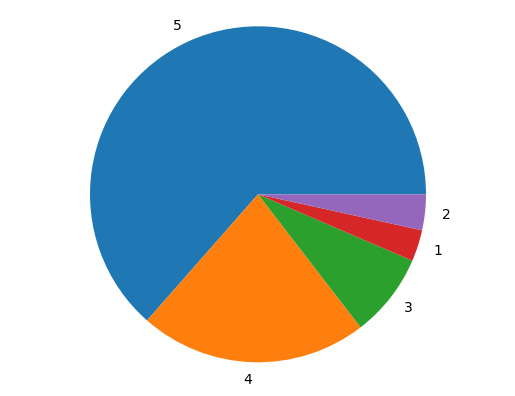

In [5]:
# Data to plot
labels = []
values = []

for x, y in elements_count.items():
    labels.append(x)
    values.append(y)

# Plot
plt.pie(values, labels=labels)

plt.axis('equal')
plt.show()
# show plot

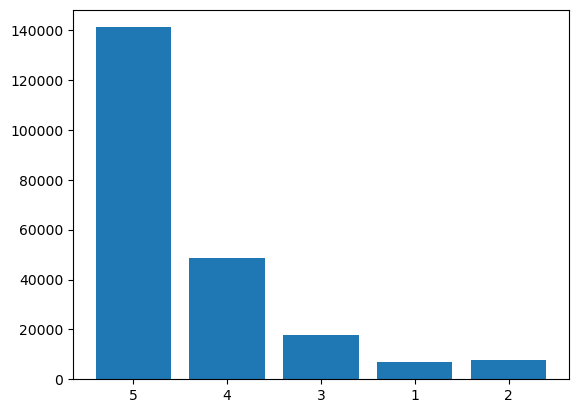

In [6]:
names = list(elements_count.keys())
values2 = list(elements_count.values())

plt.bar(range(len(elements_count)), values, tick_label=names)
plt.show()

In [7]:
import re
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {5: [],
                4: [],
                3: [],
              2: [],
              1: []}

pattern = re.compile('[^\w ]')
for text, t in zip(train_data['Review'], train_data['overall']):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)            

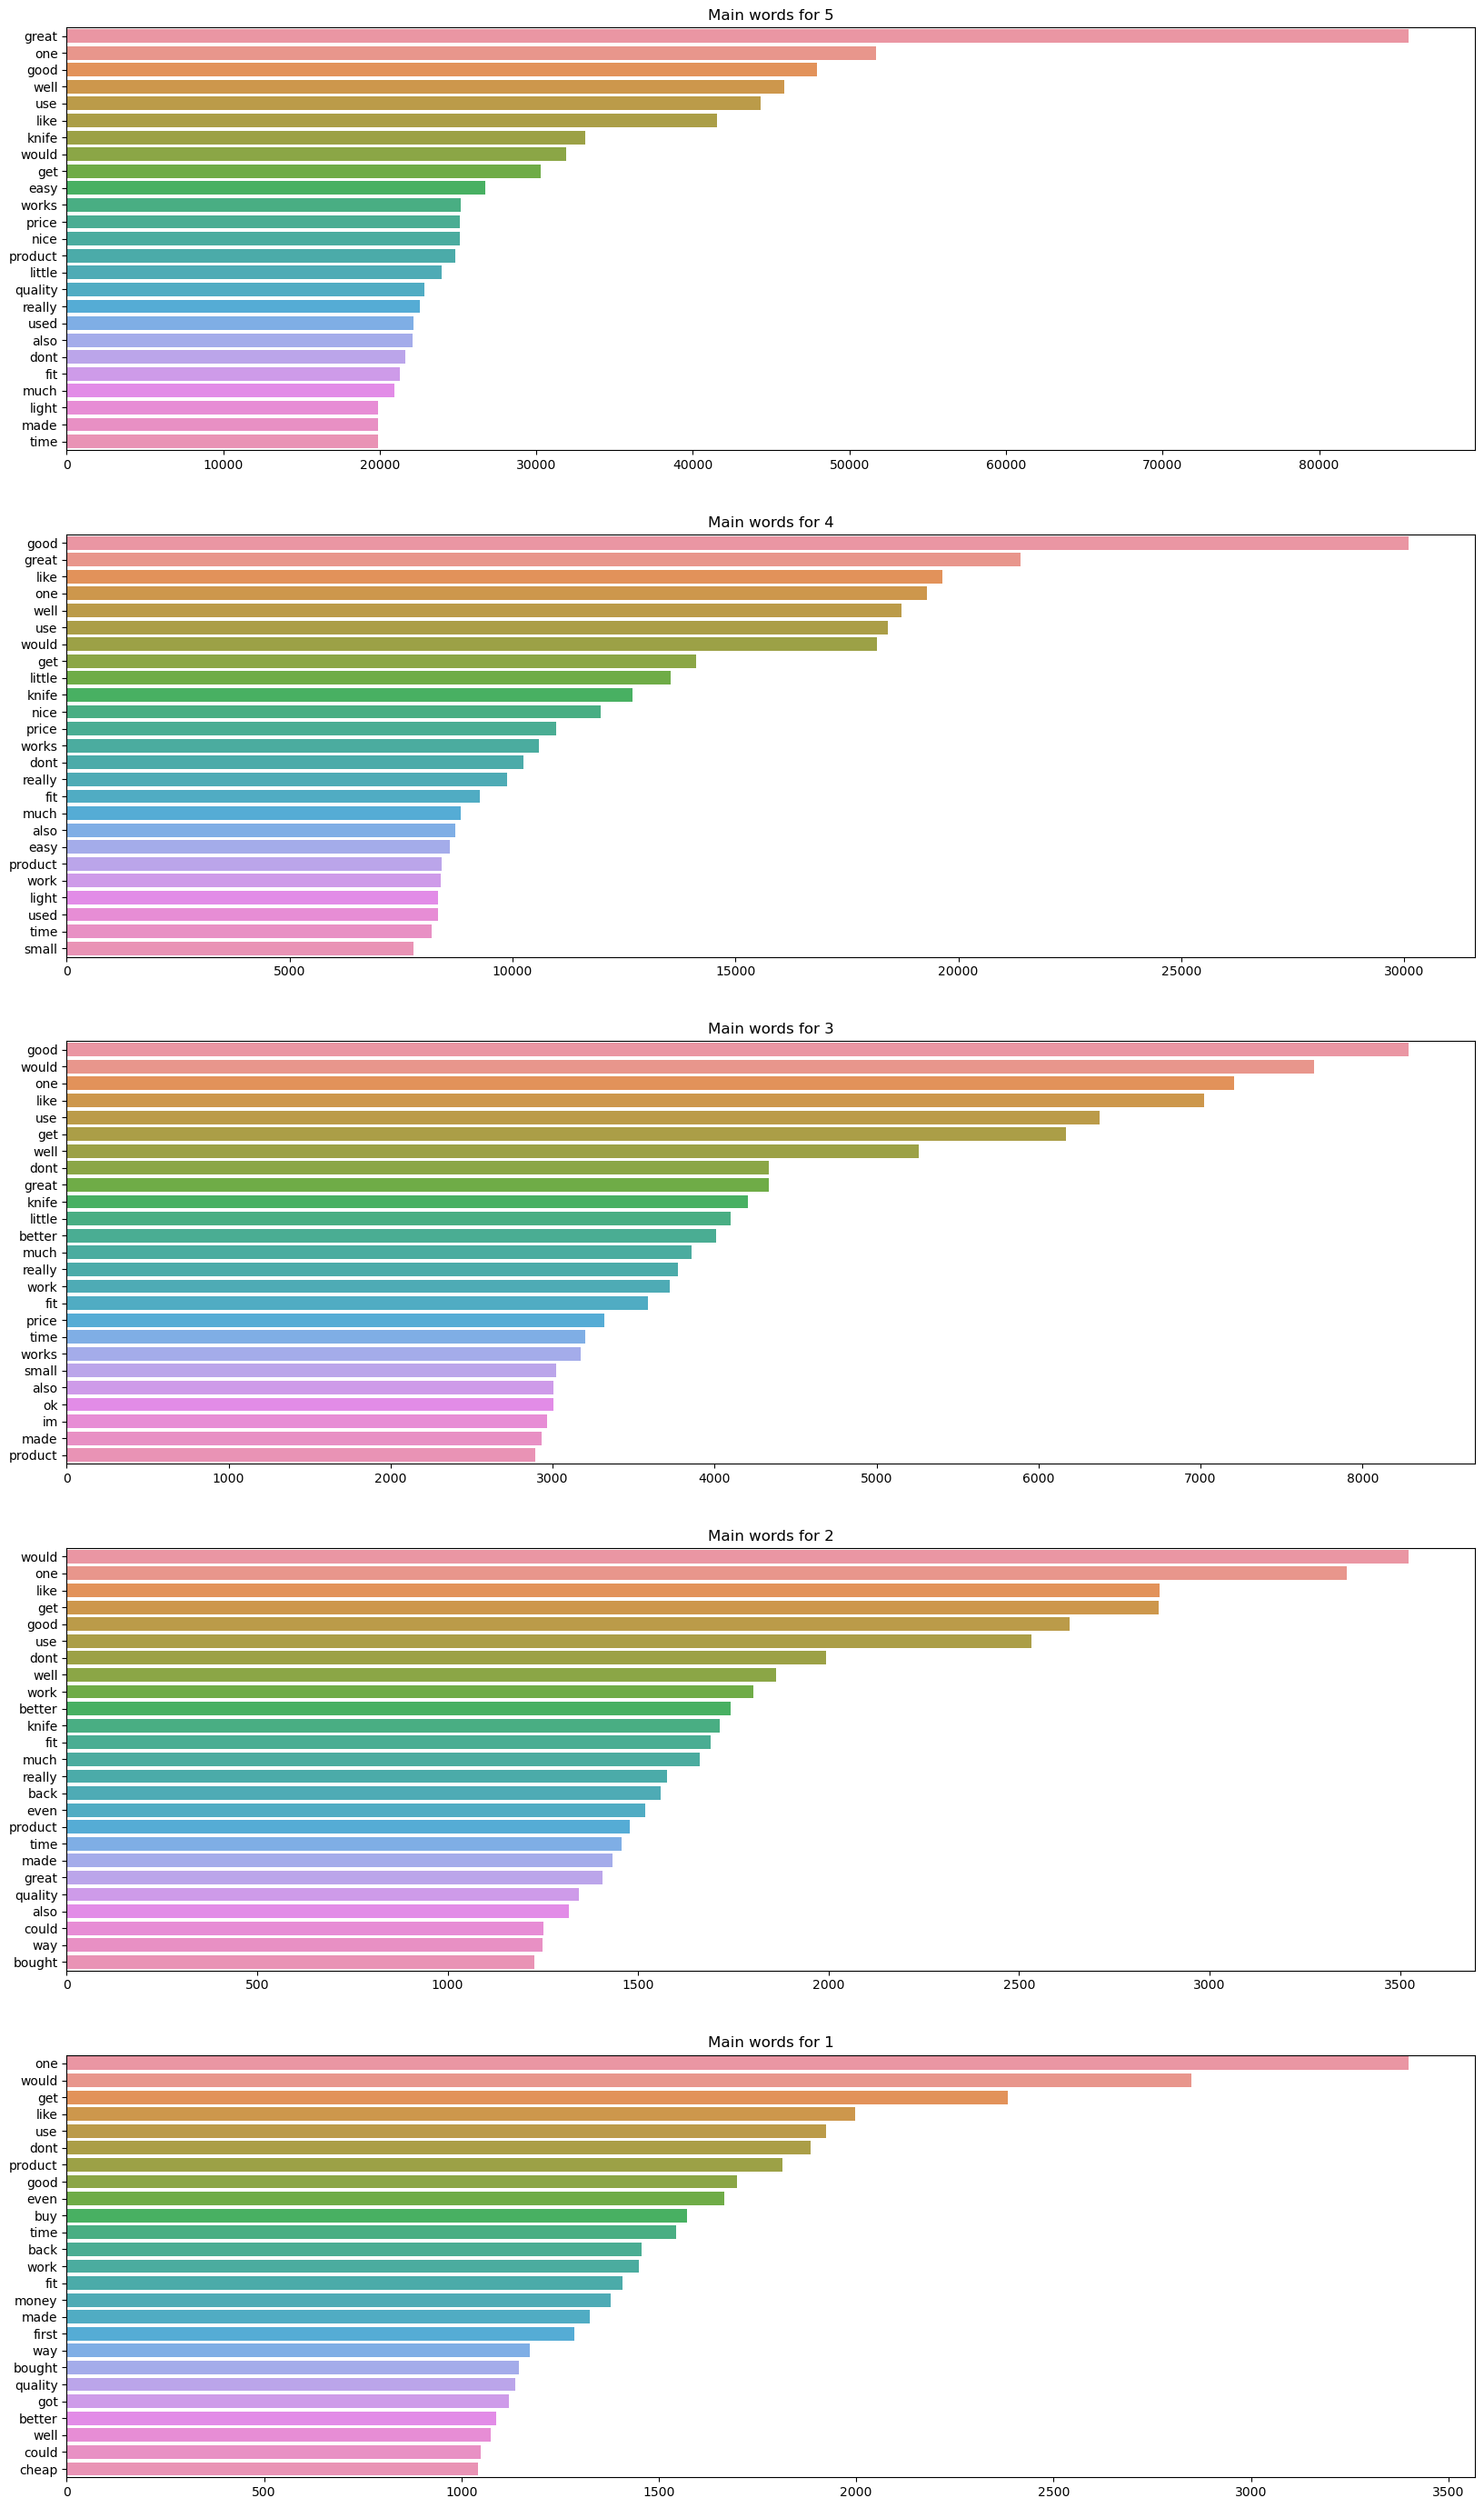

In [8]:
fig, axes = plt.subplots(5, figsize=(20,35))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Main words for {target}')
plt.show()

# Section 2:  Text Preprocessing - Lemmatization

In [9]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [10]:
train_data['lem'] = train_data['Review'].apply(lambda x:deEmojify(x))
corpus = []

for i in range(0, len(train_data['Review'])):
    review = re.sub('<.*?>+', '', train_data['Review'][i])
    review = re.sub('[%s]' % re.escape(string.punctuation), '', train_data['Review'][i])
    review = re.sub('[^a-zA-Z]', ' ', train_data['Review'][i])
    review = review.lower()
    review = review.split()
    
    review = [wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

train_data['lem'] = corpus
train_data.head()

,overall,Review,lem
0,5,This a really cool (but time-tested) design. T...,really cool time tested design carbon steel bl...
1,5,I liked the first pair so well I bought severa...,liked first pair well bought several found usu...
2,4,I took them to the range to put them to the te...,took range put test adjust volume hear people ...
3,5,What can you say about a yoga block? These ar...,say yoga block solid sturdy name brand feared ...
4,5,After reading many reviews I decided on this l...,reading many review decided light satisfied da...


In [11]:
test_data['lem'] = test_data['Review'].apply(lambda x:deEmojify(x))
corpus = []
for i in range(0, len(test_data['Review'])):
    review = re.sub('<.*?>+', '', test_data['Review'][i])
    review = re.sub('[%s]' % re.escape(string.punctuation), '', test_data['Review'][i])
    review = re.sub('[^a-zA-Z]', ' ', test_data['Review'][i])
    review = review.lower()
    review = review.split()
    
    review = [wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

test_data['lem'] = corpus
test_data.head()

,id,Review,lem
0,0,Bought for a Smith and Wesson M&P15 fits perfe...,bought smith wesson p fit perfect job reload m...
1,1,Beware of the charts listed on Butler Creek's ...,beware chart listed butler creek website dimen...
2,2,I've only used this once to sight in a scope. ...,used sight scope read review quit working tip ...
3,3,I need more of these!!! This thing makes shoot...,need thing make shooting much fun hearing gong...
4,4,Grabber Outdoors Original Space Brand Sportsma...,grabber outdoors original space brand sportsma...


In [12]:
# Define X and y
X_train = train_data['Review']
X_test = test_data['Review']
y_train = train_data['overall']

print('X_Train: ', len(X_train))
print('y_train:', len(y_train))
print('X_Test: ', len(X_test))

X_Train:  222243
y_train: 222243
X_Test:  74081


# PART 3: Feature Representation using TFIDF
- Using the n-gram tfidf vectorizer
- A numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling.

In [13]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=5000)
word_vectorizer.fit(X_train)
train_features = word_vectorizer.transform(X_train)

In [14]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=5000)
word_vectorizer.fit(X_test)
test_features = word_vectorizer.transform(X_test)

# PART 4: Model Building

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")    

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Train Test Split

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_features, y_train, test_size=0.3, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(155570, 5000) (155570,)
(66673, 5000) (66673,)


### 4.1 Model Selection
- First select the best peforming model by using cross validaton. 
- We are considering the following classification algorithms and performing the model selection process
    1. Naive Bayes
    2. Logistic Regression
    3. Random Forest
    4. XGBoost

In [17]:
#creating the objects
nb_cv = BernoulliNB()
logreg_cv = LogisticRegression(random_state=0)
randomforest_cv = RandomForestClassifier()
xgb_cv = XGBClassifier()

cv_dict = {0: 'Naive Bayes', 1: 'Logistic Regression', 2: 'Random Forest', 3: 'XGBoost'}
cv_models = [nb_cv, logreg_cv, randomforest_cv, xgb_cv]

for i, model in enumerate(cv_models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("{} Test Accuracy: {}".format(cv_dict[i], metrics.accuracy_score(y_test, y_pred)))


Naive Bayes Test Accuracy: 0.6259355361240682
Logistic Regression Test Accuracy: 0.7055779700928412
Random Forest Test Accuracy: 0.6789554992275734
XGBoost Test Accuracy: 0.6747259010394012


### 4.2 Hyperparameter Tuning - logistic regression
We use regularization parameter and penality for parameter tuning.

In [18]:
# parameter grid
parameters = {'penalty' : ['l1','l2'], 'C': np.logspace(-3,3,7),'solver': ['newton-cg', 'lbfgs', 'liblinear'],}

In [19]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [20]:
clf.fit(X_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

We get the best parameters and the accuracy:

In [21]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.7025776177926335


In [22]:
logreg = LogisticRegression(C = 1.0, 
                            penalty = 'l1', 
                            solver = 'liblinear')
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print("Accuracy:",logreg.score(X_test, y_test))

Accuracy: 0.7057579529944655


### 4.3 Model Evaluation using classification metrics
Here we plot the confusion matrix and check our f1 score

Confusion matrix, without normalization


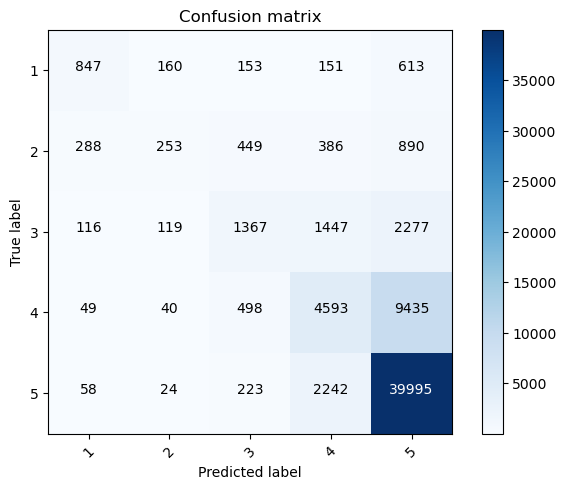

In [23]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['1', '2', '3', '4', '5'])

In [24]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           1       0.62      0.44      0.52      1924
           2       0.42      0.11      0.18      2266
           3       0.51      0.26      0.34      5326
           4       0.52      0.31      0.39     14615
           5       0.75      0.94      0.84     42542

    accuracy                           0.71     66673
   macro avg       0.57      0.41      0.45     66673
weighted avg       0.67      0.71      0.67     66673



# PART 5 : Model Text as Sequence using Word Embedding and LSTM

### Word Embedding
- Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. 
- They have learned representations of text in an n-dimensional space where words that have the same meaning have a similar representation. 
- Two similar words are represented by almost similar vectors that are very closely placed in a vector space.

### Tokenization
- We need to perform tokenization - the processing of segmenting text into sentences of words.
- The benefit of tokenization is that it gets the text into a format that is easier to convert to raw numbers, which can actually be used for processing.

In [25]:
# Define X and y
x = train_data['lem']
y = train_data['overall']

print(len(x), len(y))

222243 222243


In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, random_state=42)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

177794 177794
44449 44449


In [27]:
MAX_NB_WORDS = 5000

# get the raw text data
x_train = x_train.astype(str)
x_test = x_test.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 79103 unique tokens.


In [28]:
vocab_length = len(tokenizer.word_index) + 1
vocab_length

79104

### Pad Sequences
- Pads sentences to the same length.

In [29]:
MAX_SEQUENCE_LENGTH = 20
#pad sequences are used to bring all sentences to same size.
# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)

Shape of data tensor: (177794, 20)
Shape of data test tensor: (44449, 20)


### GloVe (Global Vectors for Word Representation)
- It helps derive semantic relationships between words from the co-occurrence matrix.
- Focuses on words co-occurrences over the whole corpus. 
- Its embeddings relate to the probabilities that two words appear together.

In [30]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [31]:
# Loading embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.013786  ,  0.38216001,  0.53236002, ..., -1.04260004,
         0.28854999,  0.63055998],
       [-0.22556999,  0.49417999,  0.48609999, ..., -0.45743999,
         0.49645999,  0.34906   ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.054505  ,  0.43399   ,  0.043026  , ...,  0.15829   ,
        -0.1697    , -0.5848    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

### Model Training using LSTM

In [32]:
## defining model 
Mymodel = tf.keras.models.Sequential([
    
    tf.keras.layers.Embedding(MAX_NB_WORDS, 128),
    tf.keras.layers.LSTM(128,input_shape=(1,)),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

Mymodel.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'] )
Mymodel.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"


2023-04-02 17:34:49.359841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-02 17:34:49.360332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 772,229
Trainable params: 772,229
Non-trainable params: 0
_________________________________________________________________


In [33]:
## training model 
retVal = Mymodel.fit(x_train, y_train, validation_data = (x_test,y_test), batch_size=32, epochs = 5 )

Epoch 1/5


2023-04-02 17:34:49.607014: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-02 17:34:50.025243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:34:50.146980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


   1/5557 [..............................] - ETA: 1:21:00 - loss: 0.7050 - accuracy: 0.0625

2023-04-02 17:34:50.303822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5557/5557 [==============================] - ETA: 0s - loss: 0.4227 - accuracy: 0.2197

2023-04-02 17:36:16.016141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-04-02 17:36:16.064092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5557/5557 [==============================] - 96s 17ms/step - loss: 0.4227 - accuracy: 0.2197 - val_loss: 0.4120 - val_accuracy: 0.2176
Epoch 2/5
5557/5557 [==============================] - 94s 17ms/step - loss: 0.4187 - accuracy: 0.2198 - val_loss: 0.4123 - val_accuracy: 0.2176
Epoch 3/5
5557/5557 [==============================] - 94s 17ms/step - loss: 0.4162 - accuracy: 0.2198 - val_loss: 0.4009 - val_accuracy: 0.2176
Epoch 4/5
5557/5557 [==============================] - 94s 17ms/step - loss: 0.4141 - accuracy: 0.2198 - val_loss: 0.4064 - val_accuracy: 0.2176
Epoch 5/5
5557/5557 [==============================] - 94s 17ms/step - loss: 0.4125 - accuracy: 0.2198 - val_loss: 0.4057 - val_accuracy: 0.2176


# PART 6: TOPIC MODELING

### 6.1 Creating Dictionary and Corpus
- Gensim's LDA requires the data in a certain format. 
- Firstly, it needs the corpus as a dicionary of id-word mapping, where each word has a unique numeric ID. This is for computationally efficiency purposes. 
- Secondly, it needs the corpus as a term-document frequency matrix which contains the frequency of each word in each document.

In [34]:
# tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):  # deacc=True removes punctuations
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

# conver to list
data = train_data['lem'].values.tolist()
data_tokenized = list(sent_to_words(data))

#sample
print(data_tokenized[3])

['say', 'yoga', 'block', 'solid', 'sturdy', 'name', 'brand', 'feared', 'would', 'le', 'dense', 'higher', 'priced', 'block', 'supportive', 'need', 'light', 'easy', 'store', 'le', 'expensive', 'good', 'quality', 'block']


In [35]:
# create dictionary and corpus
# create dictionary

id2word=corpora.Dictionary(data_tokenized)

#create corpus
corpus=[id2word.doc2bow(text) for text in data_tokenized]

# sample
print(corpus[2])

[(18, 1), (31, 1), (40, 1), (62, 1), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 2), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1)]


The (18, 1) above represents the fact that the word with id=18 appears 1 time in the second document (review), word id 12 appears twice and so on. The nested list below shows the frequencies of words in the first document.

In [36]:
# human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('affordable', 1),
  ('blade', 2),
  ('carbon', 1),
  ('cool', 1),
  ('couple', 1),
  ('design', 1),
  ('disappointed', 1),
  ('easily', 1),
  ('get', 1),
  ('knife', 2),
  ('locking', 1),
  ('maintenance', 1),
  ('mine', 1),
  ('month', 1),
  ('nice', 1),
  ('oiled', 1),
  ('open', 1),
  ('price', 1),
  ('really', 2),
  ('require', 1),
  ('screw', 1),
  ('sharp', 1),
  ('solid', 1),
  ('steel', 1),
  ('tested', 1),
  ('time', 3),
  ('top', 1),
  ('using', 1)]]

### 6.2 Building Topic Model
- We'll define 10 topics to start with. 
- The hyperparameter alpha affects sparsity of the document-topic (theta) distributions, whose default value is 1. 
- Similarly, the hyperparameter eta can also be specified, which affects the topic-word distribution's sparsity.

In [37]:
# Build LDA model
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=10,random_state=100,\
                                          update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)


In [38]:
# print the 10 topics
lda_model.print_topics()

[(0,
  '0.081*"bag" + 0.043*"case" + 0.035*"strap" + 0.035*"pack" + 0.030*"pocket" + 0.028*"carry" + 0.026*"belt" + 0.022*"clip" + 0.018*"pouch" + 0.018*"room"'),
 (1,
  '0.051*"blade" + 0.044*"tool" + 0.040*"handle" + 0.028*"box" + 0.027*"sharp" + 0.026*"steel" + 0.024*"lock" + 0.021*"edge" + 0.018*"cut" + 0.012*"ring"'),
 (2,
  '0.034*"star" + 0.028*"sturdy" + 0.025*"short" + 0.017*"fire" + 0.016*"brand" + 0.016*"feature" + 0.013*"glass" + 0.013*"bolt" + 0.013*"arm" + 0.013*"pair"'),
 (3,
  '0.029*"target" + 0.025*"ball" + 0.021*"workout" + 0.020*"watch" + 0.016*"fun" + 0.016*"band" + 0.016*"hit" + 0.015*"exercise" + 0.012*"practice" + 0.012*"door"'),
 (4,
  '0.015*"time" + 0.012*"light" + 0.012*"also" + 0.010*"bike" + 0.010*"use" + 0.009*"even" + 0.009*"back" + 0.009*"get" + 0.009*"first" + 0.008*"one"'),
 (5,
  '0.045*"water" + 0.033*"comfortable" + 0.028*"holster" + 0.026*"wear" + 0.019*"tent" + 0.019*"camping" + 0.014*"sock" + 0.013*"trip" + 0.013*"pad" + 0.012*"dry"'),
 (6,
  '0

### 6.3 Evaluating the model

In [39]:
# coherence score
coherence_model_lda=CoherenceModel(model=lda_model,texts=data_tokenized,dictionary=id2word,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score:',coherence_lda)


Coherence Score: 0.4269489793726038


### 6.4 Visualising the topics

In [40]:
# visulaise the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.328050  0.077699       1        1  34.899443
4     -0.306201  0.095058       2        1  32.487293
1      0.038210 -0.308644       3        1   4.921698
5      0.023449 -0.047115       4        1   4.862446
2      0.167742  0.152277       5        1   4.515477
0     -0.032292 -0.249445       6        1   4.360687
8      0.061711 -0.038619       7        1   4.059638
3      0.072862  0.138255       8        1   3.689079
9      0.160423  0.029736       9        1   3.311577
6      0.142147  0.150797      10        1   2.892663, topic_info=         Term           Freq          Total Category  logprob  loglift
65      great  124023.000000  124023.000000  Default  30.0000  30.0000
399       bag   36004.000000   36004.000000  Default  29.0000  29.0000
64       good   98858.000000   98858.000000  Default  28.0000  28.0000
535       gun   28539.000000   28539.000000  Default  27.0000  27.0000
223       fit   58491.000000   58491.000000  Default  26.0000  26.0000
...       ...            ...            ...      ...      ...      ...
443   forever    1467.716405    1468.656339  Topic10  -5.2995   3.5424
79      range    5952.633861   14327.211482  Topic10  -3.8994   2.6647
1519    green    2627.787805    4047.307866  Topic10  -4.7171   3.1111
586     clear    2555.743946    3973.890063  Topic10  -4.7449   3.1016
1372    front    3401.631401   10373.934623  Topic10  -4.4590   2.4280

[397 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
247       2  0.999940      able
1118      8  0.999820  accuracy
1627     10  0.999630   airsoft
329       1  0.000101      also
329       2  0.999878      also
...     ...       ...       ...
548       1  0.000096      year
548       2  0.999855      year
964       8  0.999356   youtube
1634      5  0.999865      zero
776       6  0.999678    zipper

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 6, 3, 1, 9, 4, 10, 7])

In [41]:
pyLDAvis.save_html(vis, 'topic_model.html')

# Section 7: KAGGLE Competition
- Out of all the classification models tested, logisitic regression performed the best.
- We will use this model for submitting the ratings for the kaggle competition

In [42]:
submussion = pd.read_csv('sample_submission.csv')

In [43]:
## Predicting the test set with Logistic Regression Model and saving to Mysubmission_CW2

y = logreg.predict(test_features)
submussion['overall'] = y
submussion.to_csv('Mysubmission_CW2.csv', index=False)

In [44]:
## Checking the mean of ratings score
df_Mysubmission_CW2 = pd.read_csv('Mysubmission_CW2.csv')
print("Test set score: {:.2f}".format(np.mean(df_Mysubmission_CW2.overall)))

Test set score: 4.83
